In [2]:
# import necessary libraries
import os, sys, glob
import math
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports


# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.Train as Train
import utils.Plot as Plot
import utils.WeightedCrossEntropy as WeightedCrossEntropy
import utils.BuildUNet as BuildUNet
import utils.TileGenerator as TG
import utils.DistanceMap as DistanceMap

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 07680MiB / 40537MiB
  1  | 02850MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# 1) Data Loading / Plotting

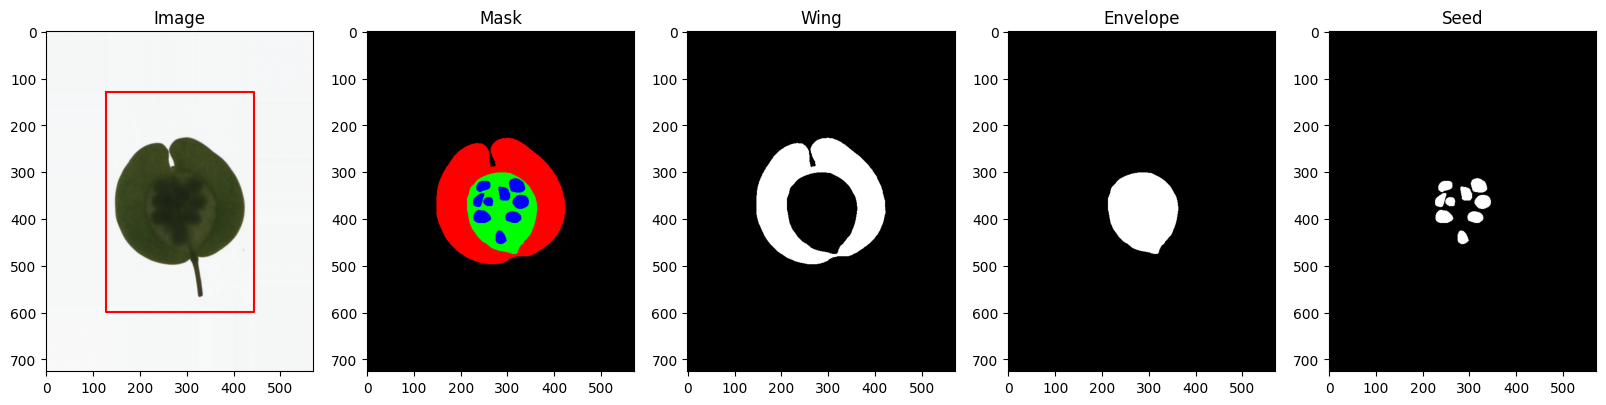

In [3]:
# define options
img_path = '../pennycress_pods/train/train_images_by_pod/'
mask_path = '../pennycress_pods/train/train_masks_by_pod/'
n_pad = 128

# load images and masks into list
mask_names = sorted([os.path.basename(x) for x in glob.glob(mask_path + '*.png')])

pennycress_images = []
pennycress_masks = []

# VISUALIZE
for img_name in mask_names:
    # load image
    image = np.array(Image.open(img_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    pennycress_images.append(image)

    # load mask
    mask = np.array(Image.open(mask_path + img_name))
    mask = (mask / 255.0) # normalize mask
    mask = np.pad(mask, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'constant', constant_values=0) # pad mask w/ constant 0 value
    pennycress_masks.append(mask)

# split masks into wing and pod and seed
wings = [m[:, :, 0] > 0.5 for m in pennycress_masks] # take red channel and booleanize
envelopes = [m[:, :, 1:].sum(-1) > 0.5 for m in pennycress_masks] # "... blue ..."
seeds = [m[:, :, 2] > 0.5 for m in pennycress_masks] # "... green ..."

# create list for multiclass masks
multiclass_masks = []

# add additional channel to pennycress masks for one-hot encoding
for mask in pennycress_masks:
    bg = mask.sum(-1) == 0 # booleanize background
    mask = np.concatenate([bg.reshape(*bg.shape, 1), mask], axis=-1) # add background channel
    multiclass_masks.append(mask)

# plot images and masks
i = np.random.randint(0, len(pennycress_images)) #select random from list of pennycress images
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(pennycress_images[i]); ax[0].set_title('Image')
# plot line around padding
ax[0].plot([n_pad, n_pad, pennycress_images[i].shape[1] - n_pad, pennycress_images[i].shape[1] - n_pad, n_pad],
           [n_pad, pennycress_images[i].shape[0] - n_pad, pennycress_images[i].shape[0] - n_pad, n_pad, n_pad], 'r')
ax[1].imshow(pennycress_masks[i]); ax[1].set_title('Mask')
ax[2].imshow(wings[i], cmap='gray'); ax[2].set_title('Wing')
ax[3].imshow(envelopes[i], cmap='gray'); ax[3].set_title('Envelope')
ax[4].imshow(seeds[i], cmap='gray'); ax[4].set_title('Seed')
plt.show()

# 2) Data Generation

Plotting training examples...


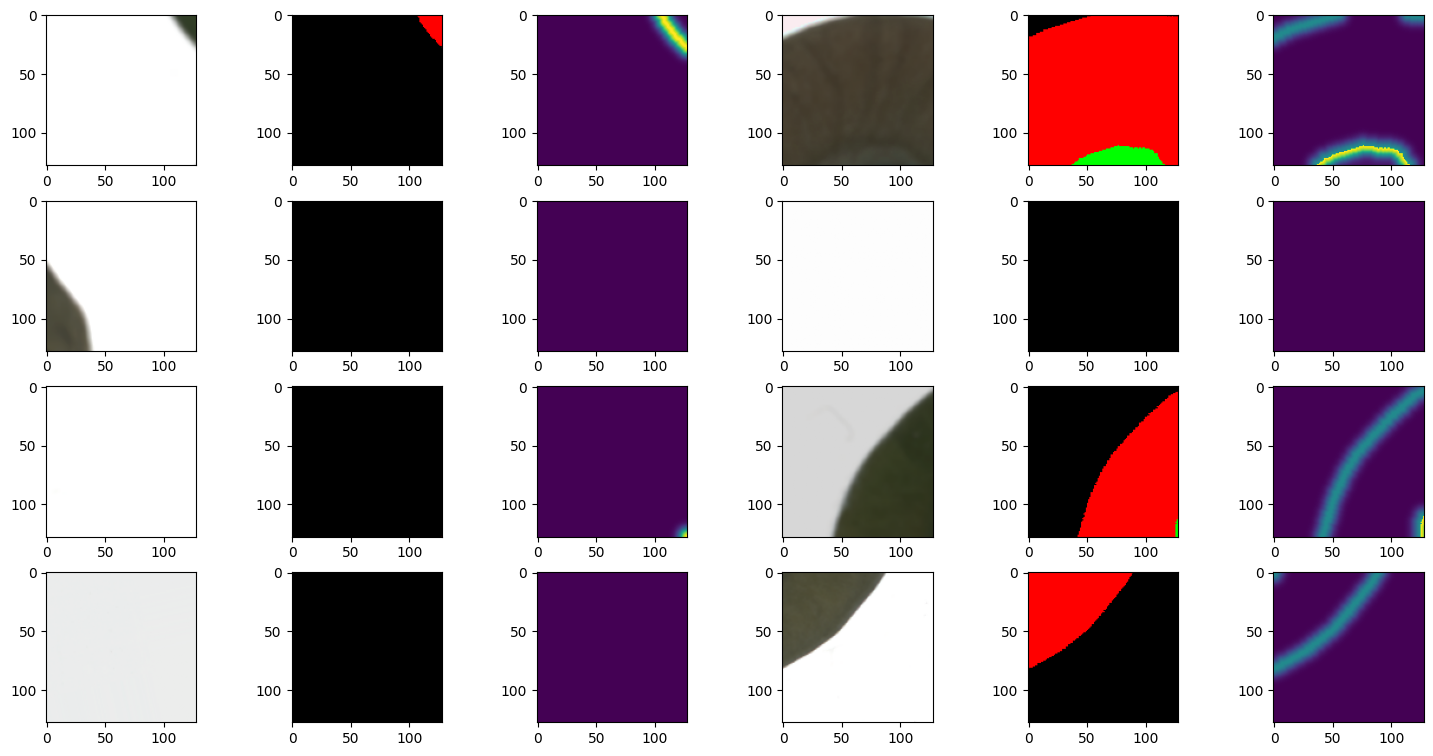

Plotting validation examples...


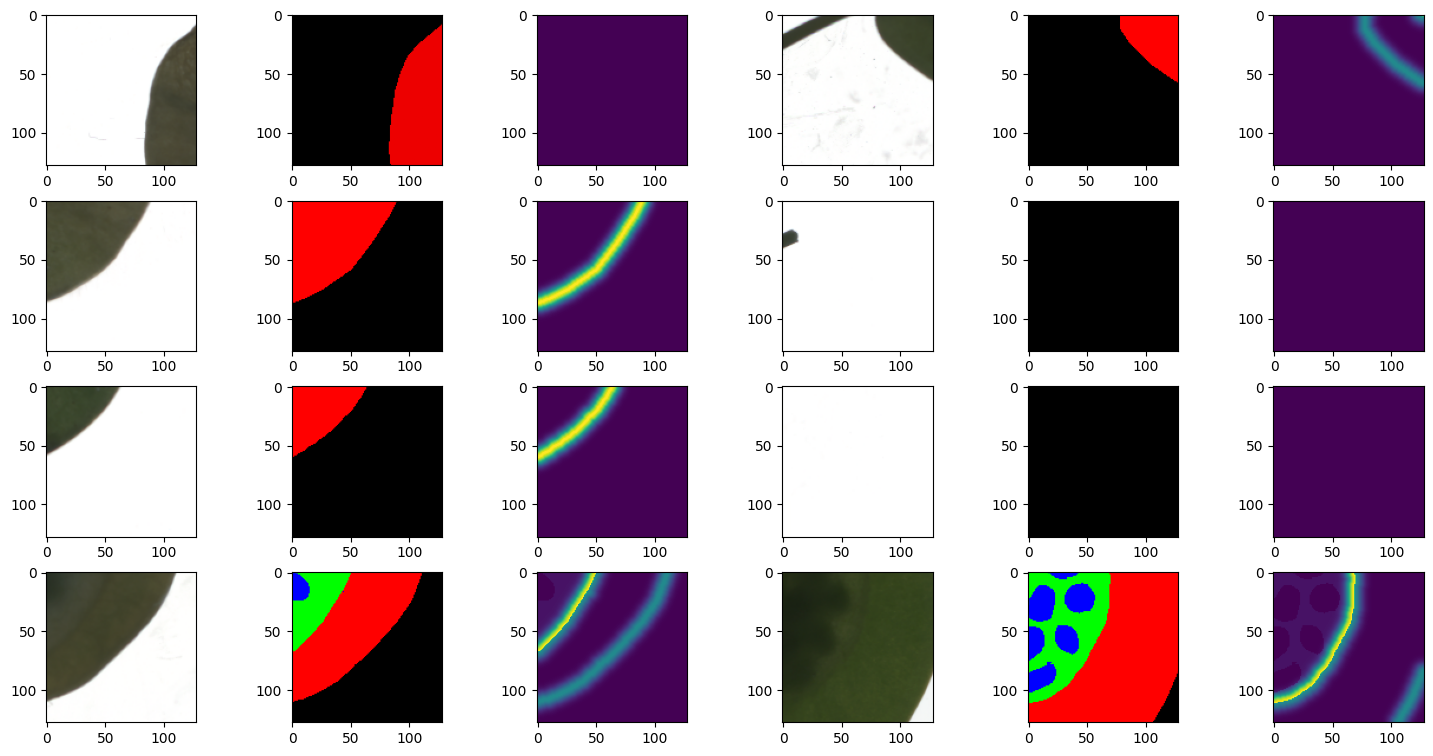

In [4]:
# whenever you run cell, re-import TG as a module
reload(TG)
reload(DistanceMap)

# options
images = pennycress_images
masks = multiclass_masks
tile_size = 128
train_prop = 0.8
distance_weights = True

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]

# instantiate tilegenerator class
train_generator = TG.TileGenerator(
    images=[images[i] for i in train_idx],
    masks=[masks[i] for i in train_idx], 
    tile_size=tile_size, 
    split='train',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

val_generator = TG.TileGenerator(
    images=[images[i] for i in val_idx],
    masks=[masks[i] for i in val_idx], 
    tile_size=tile_size, 
    split='val',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
        
        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]

        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

# Build U-Net

In [5]:
reload(BuildUNet)

model_kwargs = {
    'layer_sizes': [16, 32, 64, 128, 256],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None
}

unet = BuildUNet.UNet(**model_kwargs).to(device)

# Train Model

In [6]:
# define our loss function, optimizer
reload(WeightedCrossEntropy)
if distance_weights:
    loss_function = WeightedCrossEntropy.WeightedCrossEntropy(device=device)
else:
    loss_function = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [11]:
reload(Train)

# log options
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'

# lr options
warmup_iters = 1000
lr_decay_iters = 120000
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000

Train.train_model(model = unet,
                  loss_function = loss_function,
                  optimizer = optimizer,
                  train_generator = train_generator,
                  val_generator = val_generator,
                  log_path = log_path,
                  chckpnt_path = chckpnt_path,
                  model_kwargs = model_kwargs,
                  train_idx = train_idx,
                  val_idx = val_idx,
                  device = device
                  )

---------------------------------------
Iteration: 5000 | Best Loss: 6.3424e-01
---------------------------------------


 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

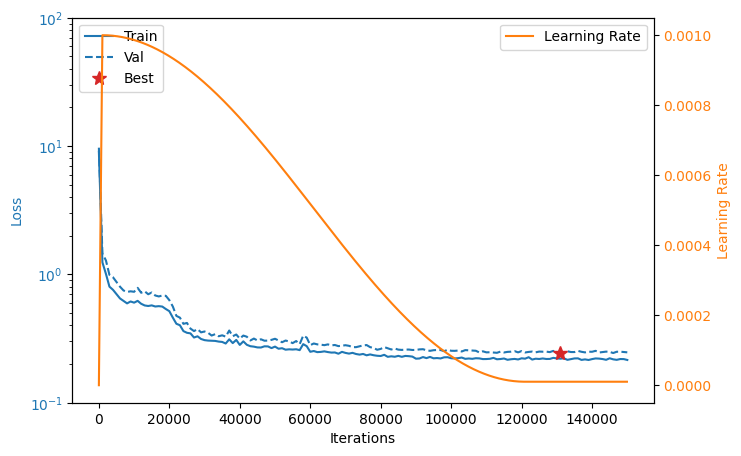

In [9]:
reload(Plot)
Plot.plot_loss(log_path='../logs/log.csv',
               warmup_iters=warmup_iters,
               lr_decay_iters=120000,
               max_lr=max_lr,
               min_lr=min_lr)

# Plot Input / Prediction Pairs on Val. Images

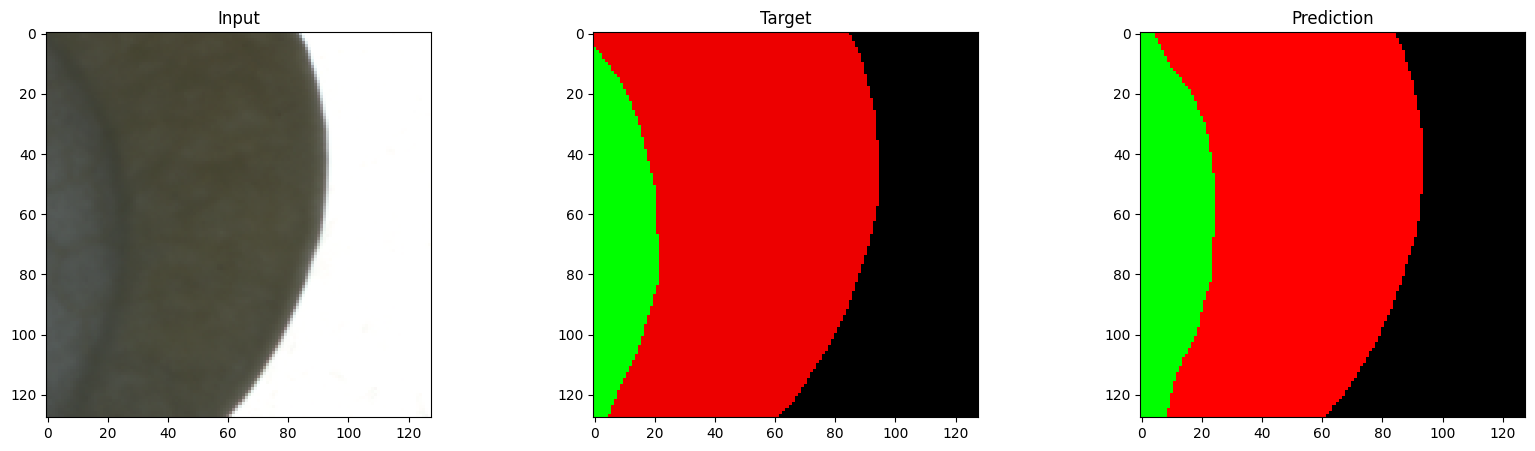

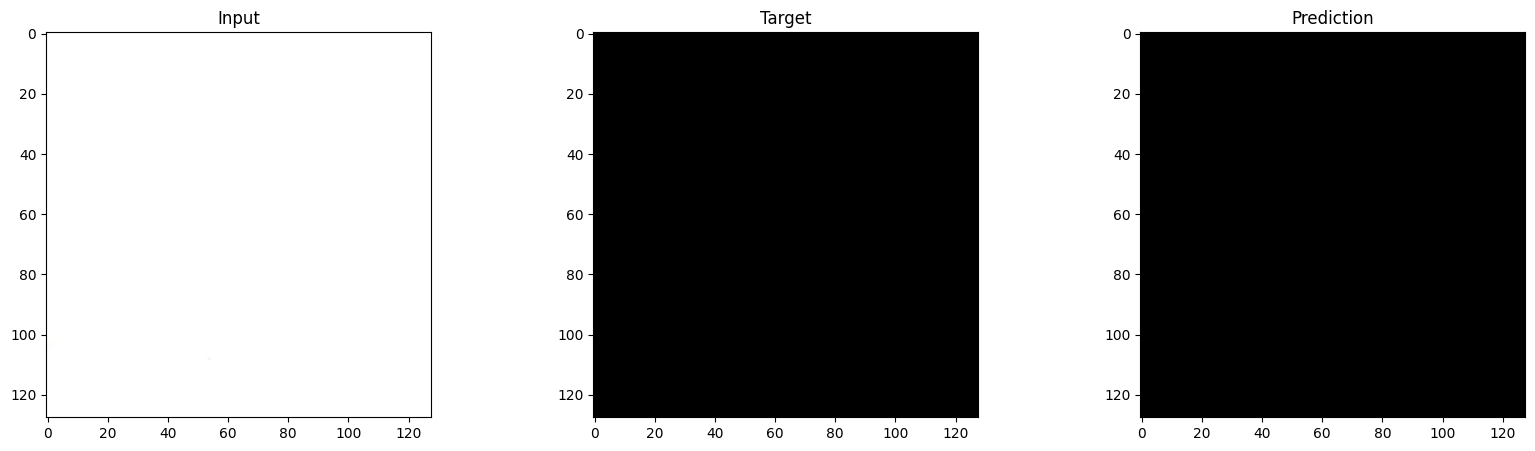

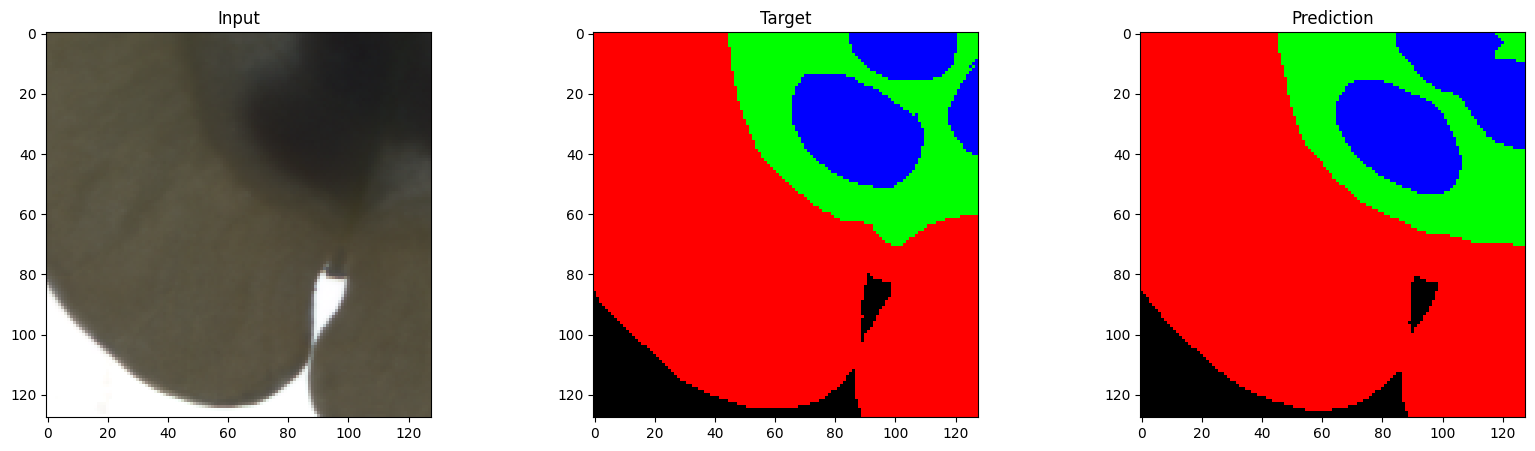

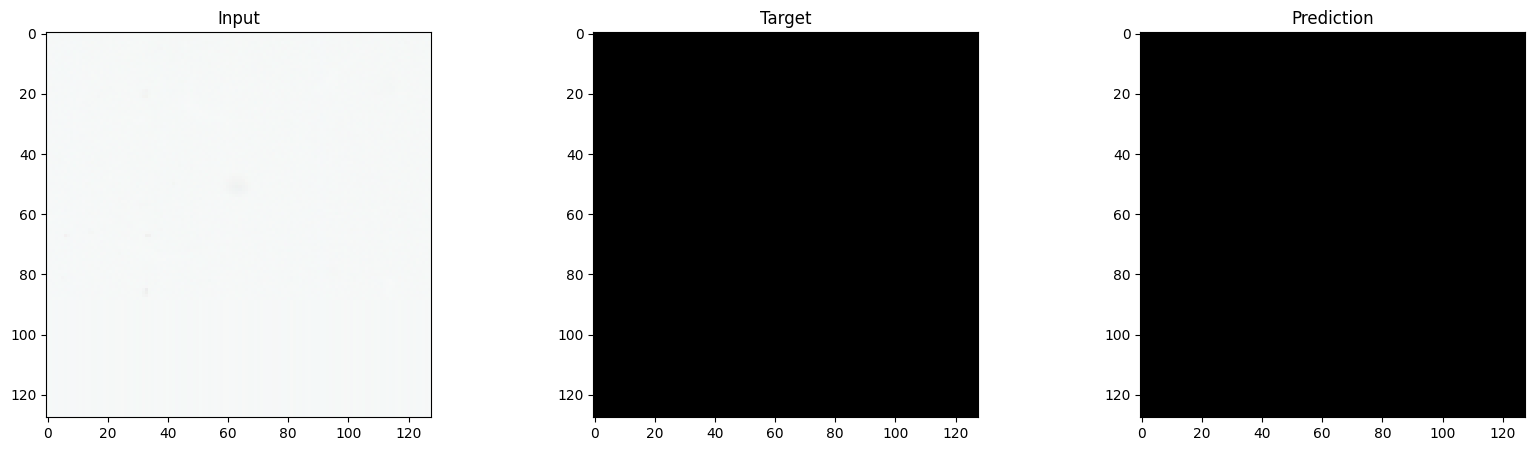

In [10]:
val_loader = DataLoader(
    val_generator, 
    batch_size=32, 
    shuffle=True,
    num_workers=32,
    pin_memory=True)

reload(Plot)
Plot.plot_val_images(val_loader=val_loader,
                     model=unet,
                     device=device)